# 08B. Metropolis algorithm

### Mingyang Lu

### 3/11/2024

# Markov ChainA Markov Chain or Markov process is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. For example, random walk is a typical Markov Chain, where a left or right move is randomly picked in each step. ### A Weather modelWe consider a simple weather model with two discrete states: "sunny" and "rainy". In each step, the weather has a chance to stay in the same state and a chance to switch to the other state. As the probability for the state transitions only depends on the current state, the system is described by a Markov Chain. The state diagram below illustrates the transition probability of the weather model.
<center> <img src="fig08B1.png", width = 40%>  </center>
<br/>### Markov Chain simulationWe can perform a Markov Chain simulation on the weather model. We will need to define a transition matrix, $T$, in which the element in the $i$th row and $j$th column is the probability of the transition from state $i$ to state $j$. Note that the row sums of the matrix need to be all one, because of a 100% for the total probability. For each step, we can use a random number from a uniform distribution to determine which transition to occur. The process can be repeated for many iterations. Below shows the implementation. 

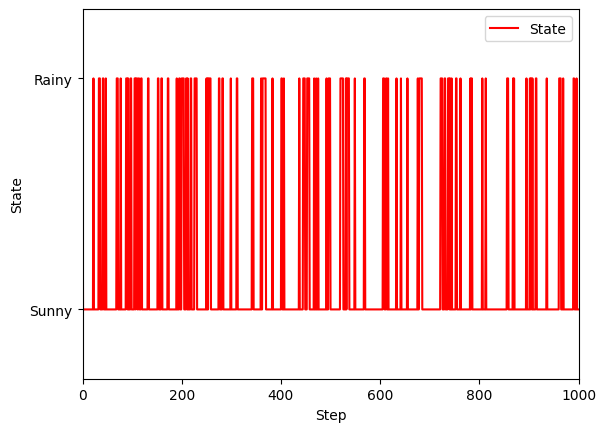

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def markov_weather(x0, nstep):
    """
    Parameters:
    # x0: initial state
    # nstep: number of simulation steps
    Output: state trajectory (a vector of size nstep + 1)
    # states (binary): 0: "Sunny"; 1: "Rainy"
    # transition matrix, 1st row: 0 -> 0; 0 -> 1; 2nd row: 1 -> 0; 1 -> 1.
    """
    transit = np.array([[0.9, 0.1], [0.5, 0.5]])
  
    x = np.zeros(nstep+1, dtype=int)
    x[0] = x0
    for i in range(nstep):
        r = np.random.uniform()
        if r < transit[x[i], 0]:
            x[i+1] = 0
        else:
            x[i+1] = 1
    return x

np.random.seed(1)
nstep = 10**4
results_weather = markov_weather(x0=1, nstep=nstep)
plt.plot(range(1001), results_weather[:1001], 'r-', label='State')
plt.xlabel('Step')
plt.ylabel('State')
plt.yticks([0, 1], ['Sunny', 'Rainy'])
plt.xlim(0, 1000)
plt.ylim(-0.3, 1.3)
plt.legend()
plt.show()


From the model trajectory, there is a longer waiting time for the transition from state 1 ("Sunny") to state 2 ("Raniny").

Q: how to write a function to simulate a Markov Chain with more than two states?

From the trajectory, we can compute the probability of the weather in each state. Here, we use the *cumsum* function to obtain the state probabilities computed from different number of steps. 


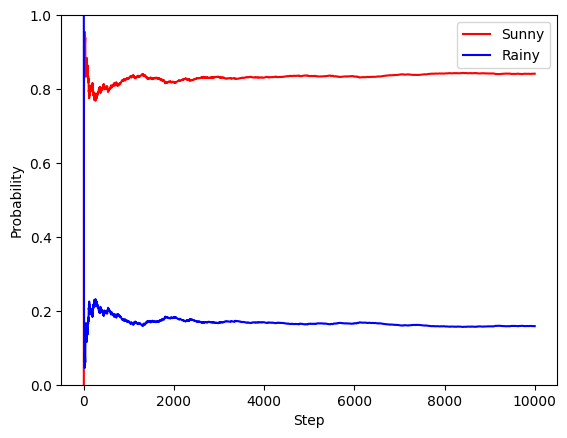

0.8414158584141586 0.15858414158584141


In [2]:
p_sunny = np.cumsum(results_weather == 0) / np.arange(1, len(results_weather)+1)
p_rainy = np.cumsum(results_weather == 1) / np.arange(1, len(results_weather)+1)
plt.plot(range(1, nstep + 2), p_sunny, 'r-', label='Sunny')
plt.plot(range(1, nstep + 2), p_rainy, 'b-', label='Rainy')
plt.xlabel('Step')
plt.ylabel('Probability')
plt.ylim(0, 1)
plt.legend()
plt.show()

print(p_sunny[-1], p_rainy[-1])

### Steady-state probability distribution

There is another way (which is more efficient) to compute the probability distribution of the weather states. Suppose we start with the rainy state (state 2), thus the initial probability distribution is $p_0 = (0, 1)$. The probability distribution for step $i+1$ is

$$p_{i+1} = p_i T \tag{1}$$
where $T$ is the transition matrix. Here, the right hand side of Equation (1) has an operation of matrix multiplication. 

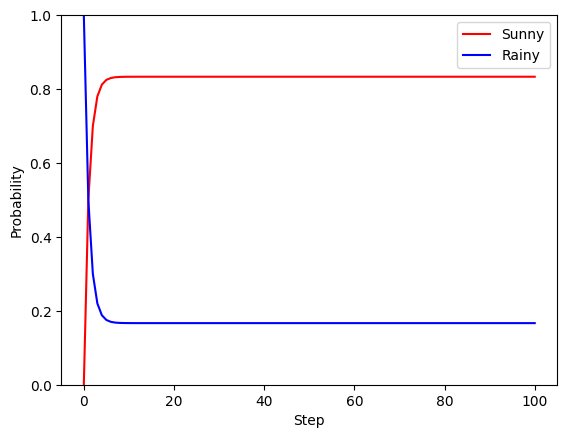

[0.83333333 0.16666667]


In [3]:
def markov_weather_prob(p0, nstep):
    transit = np.array([[0.9, 0.1], [0.5, 0.5]])
    p = np.zeros((nstep + 1, 2))
    p[0, :] = p0
    for i in range(1, nstep + 1):
        p[i, :] = p[i - 1, :] @ transit
    return p

nstep = 100
prob_weather = markov_weather_prob(np.array([0, 1]), nstep)
p_ss = prob_weather[-1, :]

plt.plot(range(nstep + 1), prob_weather[:, 0], 'r-', label='Sunny')
plt.plot(range(nstep + 1), prob_weather[:, 1], 'b-', label='Rainy')
plt.xlabel('Step')
plt.ylabel('Probability')
plt.ylim(0, 1)
plt.legend()
plt.show()

print(p_ss)


As shown in the plot, the probability distribution $p_i$ quickly reaches to a constant probability distribution -- a steady-state probability distribution $p_{ss}$ (also called stationary distribution). $p_{ss}$ is close to the probability distribution obtained from the previous Markov Chain simulation.

A Markov Chain has a unique steady-state distribution if the model satisfies the following two criteria:

* Irreducible: any state is reachable from any other state eventually (*i.e.*, the expected number of steps is finite).
* Aperiodic: the system does not return to the same state at fixed intervals (*e.g.*, not returning to the "sunny" state deterministically every 5 steps).

Systems satisfying the above criteria are called *ergodic*, an important requirement for Markov Chain Monte Carlo.

# Metropolis-Hastings algorithm

A Markov Chain Monte Carlo (MCMC) is a method to sample a probability distribution by constructing a Markov Chain. Here, the steady-state distribution of the Markov Chain is the desired probability distribution. The most popular MCMC method is the Metropolis-Hastings algorithm.

The Metropolis-Hastings algorithm also requires additional condition, called *detailed balance*, in that

$$T(x \rightarrow x') P(x) = T(x' \rightarrow x) P(x'). \tag{2}$$
$T(x \rightarrow x')$ represents the transition probability from a state $x$ to another state $x'$. $P(x)$ is the probability of state $x$ -- the desired probability distribution to sample. 

Note that, for a steady-state $P(x)$, according to the probability conservation,

$$\sum_{x'}{T(x \rightarrow x') P(x)} = \sum_{x'}{T(x' \rightarrow x) P(x')}. \tag{3} $$
Under the condition of detailed balance as shown in Equation (2), Equation (3) is always satisfied. However, for a steady-state condition as shown in Equation (3), detailed balance is not guaranteed. Thus, detailed balance condition is stronger. Detailed balance is valid for an equilibrium system. 

In the Metropolis-Hastings algorithm, a Markov Chain is constructed as follows. First, we propose a transition from $x$ to $x'$ with a proposal distribution $g(x \rightarrow x')$ (a move set). Here, $g$ can be very different from $T$. 

Second, the proposed move is accepted according to the acceptance probability

$$a  = min(1, \frac{P(x')g(x' \rightarrow x)}{P(x)g(x \rightarrow x')}). \tag{4}$$
Third, if the proposal is accepted, the next $x$ becomes $x'$; otherwise, next $x$ stays the same $x$. 

It can be shown that the constructed Markov Chain as the unique steady-state probability distribution of $P(x)$. 

### The weather model revisited

Let's consider the weather model again. We wish to sample the weather states according to the steady-state probability distribution. However, we would not sample the states according to the actual transition matrix (as in the Markov Chain model), but according to the Metropolis-Hastings algorithm. 

We set $g(0 \rightarrow 1) = g(1 \rightarrow 0) = 1$. Thus,

$$a  = min(1, \frac{P(x')}{P(x)}). \tag{5}$$

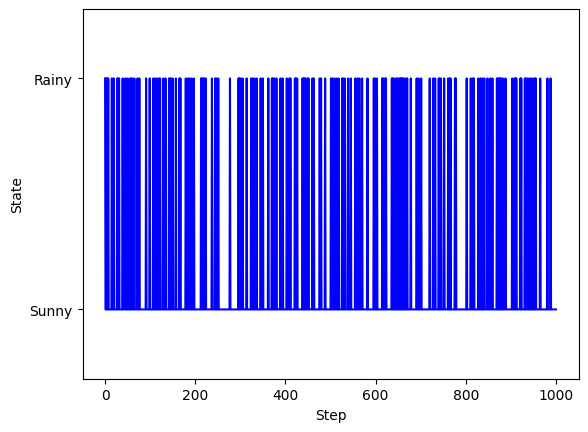

In [4]:
def metropolis_weather(x0, p_ss, nstep):
    x = np.zeros(nstep + 1, dtype=int)
    x[0] = x0
    for i in range(nstep):
        xnew = 1 - x[i]  # 0 -> 1; 1 -> 0;
        a = min(1, p_ss[xnew] / p_ss[x[i]])
        if np.random.uniform() < a:
            x[i+1] = xnew
        else:
            x[i+1] = x[i]
    return x

np.random.seed(1)
nstep = 10 ** 4
results_weather2 = metropolis_weather(x0=1, p_ss=p_ss, nstep=nstep)
plt.plot(range(1001), results_weather2[:1001], 'b-')
plt.xlabel('Step')
plt.ylabel('State')
plt.yticks([0, 1], ['Sunny', 'Rainy'])
plt.ylim(-0.3, 1.3)
plt.show()


The state transition properties look different from the weather model. However, the state probability distribution is well preserved, as shown below.

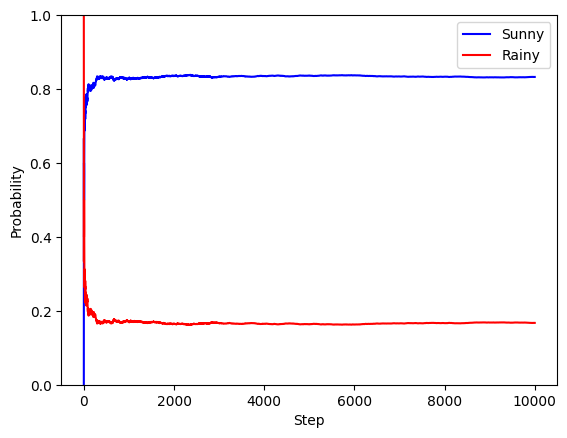

In [5]:
p_sunny2 = np.cumsum(results_weather2 == 0) / np.cumsum(np.ones(len(results_weather2)))
p_rainy2 = np.cumsum(results_weather2 == 1) / np.cumsum(np.ones(len(results_weather2)))

plt.plot(range(nstep + 1), p_sunny2, 'b-', label='Sunny')
plt.plot(range(nstep + 1), p_rainy2, 'r-', label='Rainy')
plt.xlabel('Step')
plt.ylabel('Probability')
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.show()

We can check the transition probability from the sampling trajectory.

In [6]:
def cal_transit(x_all):
    nstep = len(x_all) - 1
    unique_states = np.unique(x_all)
    n = len(unique_states)
    transit = np.zeros((n, n))  # Save counts of state transitions
    for i in range(nstep):
        transit[x_all[i], x_all[i+1]] += 1
    total_counts = np.sum(transit, axis=1)
    transit = transit / total_counts[:, np.newaxis]
    return transit

# Call the function with the simulation results
print(cal_transit(results_weather))  # Transition matrix of the Markov chain model
print(cal_transit(results_weather2))  # Transition matrix of the Metropolis sampling

[[0.90349418 0.09650582]
 [0.51261034 0.48738966]]
[[0.7992074 0.2007926]
 [1.        0.       ]]


### Sampling a Gaussian distribution

As a second example, we illustrate how Metropolis-Hastings algorithm samples a Gaussian distribution $P(x) \sim e^{-x^2}$. In the implementation below, we start from the origin ($x=0$). In each iteration, we propose a move $x' = x + dx$, where the move step $dx$ is sampled randomly from a uniform distribution, $(-dx_{max}, dx_{max})$. Here, $dx_{max}$ is the maximum magnitude of $dx$. Such a choice of $dx$ ensures the ergodic condition and $g(x' \rightarrow x) = g(x \rightarrow x')$. Thus,

$$a  = min(1, \frac{P(x')}{P(x)}) = min(1, e^{-x'^2+x^2}). \tag{6}$$

Below shows the implementation of this MCMC sampling. From the simulation, we compare the histogram of sampled $x$ with the actual distribution $P(x)$ (red curve). We monitor the number of accepted moves, from which we can obtain the acceptance rate.


Acceptance rate: 0.9725


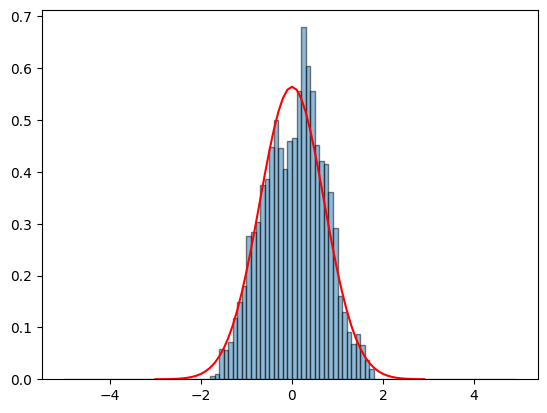

In [7]:
def metropolis_exp(nstep, dx_max):
    x = np.zeros(nstep + 1)
    num_accept = 0
    for i in range(nstep):
        dx = np.random.uniform(low=-dx_max, high=dx_max)
        xnew = x[i] + dx
        a = min(1, np.exp(-xnew**2 + x[i]**2))
        if np.random.uniform() < a:
            x[i+1] = xnew
            num_accept += 1
        else:
            x[i+1] = x[i]

    acceptance_rate = num_accept / nstep
    print(f"Acceptance rate: {acceptance_rate}")
    return x

np.random.seed(1)
nstep = 10**4
x_sample = np.arange(-3, 3, 0.1)
breaks = np.arange(-5, 5, 0.1)

results_exp = metropolis_exp(nstep=nstep, dx_max=0.1)
plt.hist(results_exp, density=True, bins=breaks, alpha=0.5, histtype='bar', ec='black')
plt.plot(x_sample, np.exp(-x_sample**2) / np.sqrt(np.pi), color='red')
plt.show()

Acceptance rate: 0.8535


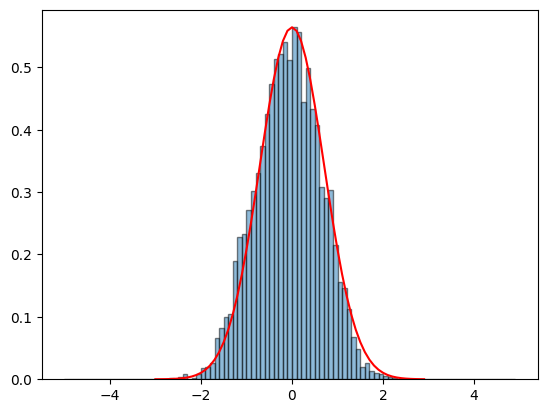

In [8]:
results_exp = metropolis_exp(nstep=nstep, dx_max=0.5)
plt.figure()
plt.hist(results_exp, density=True, bins=breaks, alpha=0.5, histtype='bar', ec='black')
plt.plot(x_sample, np.exp(-x_sample**2) / np.sqrt(np.pi), color='red')
plt.show()

Acceptance rate: 0.5161


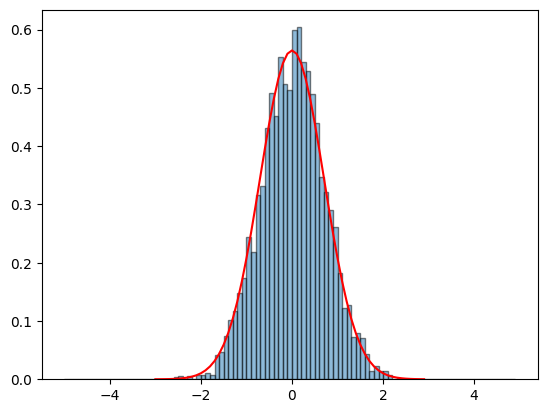

In [9]:
results_exp = metropolis_exp(nstep=nstep, dx_max=2.0)
plt.figure()
plt.hist(results_exp, density=True, bins=breaks, alpha=0.5, histtype='bar', ec='black')
plt.plot(x_sample, np.exp(-x_sample**2) / np.sqrt(np.pi), color='red')
plt.show()

Acceptance rate: 0.1082


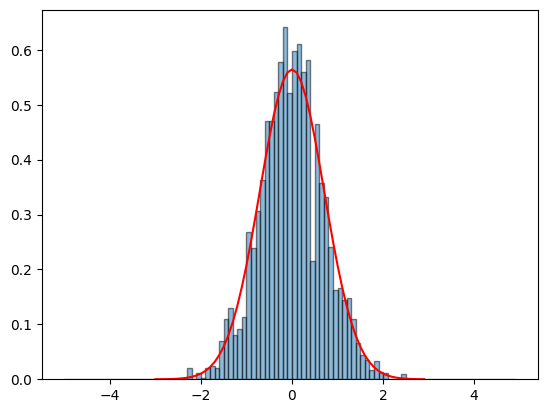

In [10]:
results_exp = metropolis_exp(nstep=nstep, dx_max=10.0)
plt.figure()
plt.hist(results_exp, density=True, bins=breaks, alpha=0.5, histtype='bar', ec='black')
plt.plot(x_sample, np.exp(-x_sample**2) / np.sqrt(np.pi), color='red')
plt.show()

We chose different move step sizes in the above applications. A larger move step would decrease the acceptance rate but increase the range of $x$ sampling. Too large or too small move step sizes would reduce the efficiency of the sampling. In this case, the sampling results are much better when the acceptance rate is around 50%.

The application here is quite straightforward. But the Metropolis-Hastings algorithm becomes very powerful when modeling more complex systems where the properties of state transitions are hard to be described.

### 1D Ising model

Ising model is a model of ferromagnetism in physics. It was widely used as a toy model for studying multi-body interactions and multi-stability. We consider an array of lattice in 1D, where each lattice site $i$ is occupied by a spin $s_i$ with two states: +1 (upward spin) and -1 (downward spin). Here, the spins represent magnetic dipole moments of atomic "spins". 

<center> <img src="fig08B2.png", width = 40%>  </center>
<br>

The total energy of the Ising model with $n$ spins is

$$ E = - \sum_{i=1}^{n-1}{Js_i s_{i+1}} \tag{7}$$

Only two spins next to each other (*e.g.*, $s_i$ and $s_{i+1}$) can interact. Their energy is negative (favored) when the two spins have the same signs, and the energy is positive (disfavored) when the two spins have the opposite signs. See below for the code to calculate the total energy of the Ising model.

In [11]:
def e_ising(J, x):
    # J: interaction strength
    # x: states of the spins (1 or -1) -- a vector
    x_shift = np.concatenate((x[1:], [0]))
    e = -np.sum(x * x_shift) * J
    return e

Q: How does the function compute the total energy? One can also use a periodic boundary condition. How to achieve this?

### Sampling a Boltzmann distribution

For a system in equilibrium at a constant temperature $T$, the probability of the system in a certain state follows a Boltzmann distribution:

$$p \sim e^{-\frac{E}{kT}}, \tag{8}$$

where $k$ is the Boltzmann constant. Here, we set $k=1$ and scaled $T$. We can use Metropolis-Hastings algorithm to sample the states of the Ising model following a Boltzmann distribution. We propose a "move" by randomly selecting spin and flipping the sign. The proposed move is accepted if

$$a  = min(1, \frac{P(x')}{P(x)}) = min(1, e^{-(E_{x'} - E_x)/T}). \tag{9}$$

Acceptance rate: 0.217


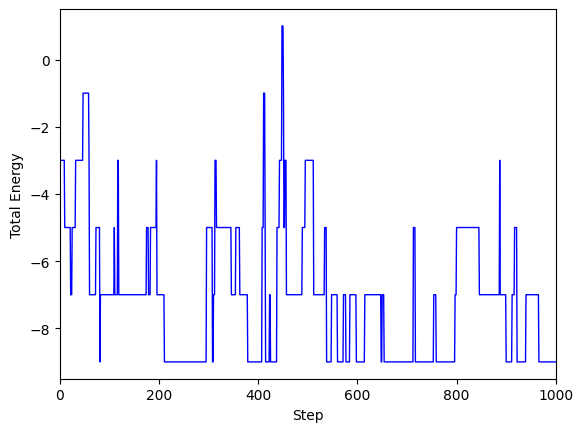

In [12]:
def metropolis_ising_1st(nstep, n, J, T):
    # nstep: number of steps
    # n: number of spins (one dimensional)
    # J: interaction strength
    # T: temperature (after scaling)
    x = np.zeros((nstep + 1, n), dtype=int)  # states
    e = np.zeros(nstep + 1)  # total energy
    x[0, :] = np.random.choice([-1, 1], size=n)  # random initial condition
    e[0] = e_ising(J, x[0, :])
    num_accept = 0
    for i in range(nstep):
        k = np.random.randint(0, n)  # randomly select a spin
        xnew = np.copy(x[i, :])
        xnew[k] *= -1  # flip the spin
        enew = e_ising(J, xnew)
        a = min(1, np.exp(-(enew - e[i]) / T))
        if np.random.uniform() < a:
            x[i + 1, :] = xnew
            e[i + 1] = enew
            num_accept += 1
        else:
            x[i + 1, :] = x[i, :]
            e[i + 1] = e[i]
    print("Acceptance rate:", num_accept / nstep)
    return {'x': x, 'e': e}

np.random.seed(1)
nstep = 10**3
results_ising = metropolis_ising_1st(nstep=nstep, n=10, J=1, T=1)
plt.plot(np.arange(nstep + 1), results_ising['e'], 'b-', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Total Energy')
plt.xlim(0, nstep)
plt.show()

The acceptance rate is around 20%. The MCMC method samples the state(s) of minimum energy (*i.e.*, -9) and other states back and forth. 

Q: We use $T = 1$. How does the acceptance rate change when the temperature increases or decreases? How does the acceptance rate change when changing $J$?

### A more efficient implementation

There are two places where we can improve the efficiency of the implementation. 

First, since the spin interactions are local, we just need to compute the differences in energy by only considering the affected energy terms. For a flip in spin $i$, the energy difference between the new and previous states is

$$\Delta E = \begin{cases}
  2Js_1s_2  & i = 1 \\
  2Js_{n-1}s_n & i = n \\
  2Js_{i-1}s_i + 2Js_is_{i+1} & otherwise
\end{cases}. \tag{10}$$

Here, all $s_i$ terms are the current states of the spins (not the states from the proposed move).

Q: Could you explain how Equation (10) computes the energy differences?

In [13]:
import numpy as np

def de_ising(J, x, n, i):
    """
    # J: interaction strength
    # x: states of the spins (1 or -1) -- a vector
    # n: number of spins
    # i: the spin with a flip
    """
    if i == 0:
        de = 2 * J * x[0] * x[1]
    elif i == n - 1:
        de = 2 * J * x[n - 1] * x[n - 2]
    else:
        de = 2 * J * x[i] * (x[i - 1] + x[i+1])
    return de

np.random.seed(1)
n = 10
J = 1
x = np.random.choice([-1, 1], size=n, replace=True)
e0 = e_ising(J, x)

for i in range(n):
    x1 = np.copy(x)
    x1[i] *= -1
    e1 = e_ising(J, x1)
    de = de_ising(J, x, n, i)
    print([i + 1, e1 - e0, de])


[1, 2, 2]
[2, 0, 0]
[3, 0, 0]
[4, 0, 0]
[5, 0, 0]
[6, 4, 4]
[7, 4, 4]
[8, 4, 4]
[9, 0, 0]
[10, -2, -2]


In a more complex system, one may consider to create a *neighbor list* to save the indices for those that are required for updating interaction/energy terms. 

Second, the acceptance probability doesn't need to be computed (which requires an evaluation of an exponential function) when the energy difference is negative (favored). Thus, when $\Delta E < 0$ the proposed move is accepted. When $\Delta E > 0$, the acceptance probability is $e^{-\frac{\Delta E}{T}}$.


Acceptance rate: 0.26766666666666666
Mean energy: -6.518827057647451


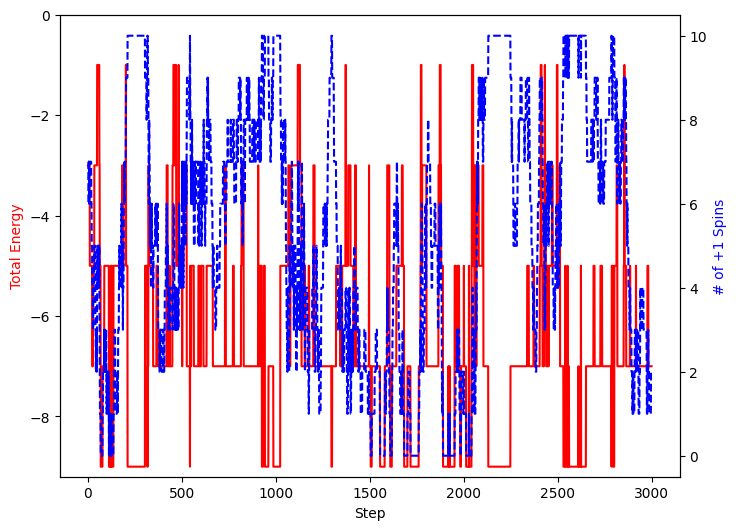

In [14]:
def metropolis_ising_improved(nstep, n, J, T):
    """
    # nstep: number of steps
    # n: number of spins (one dimensional)
    # J: interaction strength
    # T: temperature (after scaling)
    """
    x = np.zeros((nstep + 1, n))  # states
    e = np.zeros(nstep + 1)  # total energy
    x[0, :] = np.random.choice([-1, 1], size=n, replace=True)  # random initial condition
    e[0] = e_ising(J, x[0, :])
    num_accept = 0

    for i in range(nstep):
        k = np.random.randint(n)  # randomly select a spin
        de = de_ising(J, x[i, :], n, k)
        
        if de < 0 or np.random.rand() < np.exp(-de / T):
            x[i + 1, :] = x[i, :]
            x[i + 1, k] *= -1  # flip the spin
            e[i + 1] = e[i] + de
            num_accept += 1
        else:
            x[i + 1, :] = x[i, :]
            e[i + 1] = e[i]

    print("Acceptance rate:", num_accept / nstep)
    return x, e

np.random.seed(1)
nstep = 3 * 10**3
results_ising, energies_ising = metropolis_ising_improved(nstep, n=10, J=1, T=1)
print("Mean energy:", np.mean(energies_ising))

num_1 = np.sum(results_ising == 1, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(range(nstep + 1), energies_ising, color='red', label='Total energy')
plt.xlabel('Step')
plt.ylabel('Total Energy', color='red')
plt.ylim(-9.2, 0)
plt.twinx()
plt.plot(range(nstep + 1), num_1, color='blue', linestyle='--', label='# of +1 Spins')
plt.ylabel('# of +1 Spins', color='blue')
plt.xlabel('Step')
plt.show()


In the above plot, blue trajectory shows the number of spins with the state +1. It's clear that the system has two states corresponding to the lowest total energy $E = -9$: one with ten +1 spins, and the other with zero +1 spin (ten -1 spins). The Metropolis-Hastings algorithm can sample states of various energy levels under constant temperature $T = 1$, and various states of the same energy.Q: Try the Metropolis-Hastings simulations for a few initial conditions. Do you always get the same outcome?The above code also computes the mean energy from the MCMC sampling. This calculation is called an ensemble average, which is equivalent to an time average for an equilibrium system, as long as a sufficiently large number of samples are used in the calculation.For a lower temperature $T = 0.3$, it becomes much harder to undergo state transitions towards a higher energy state. Thus, the algorithm mostly samples one of the lowest energy state (*e.g*, in this case, the one with ten +1 spins).

Acceptance rate: 0.024333333333333332
Mean energy: -8.712095968010663


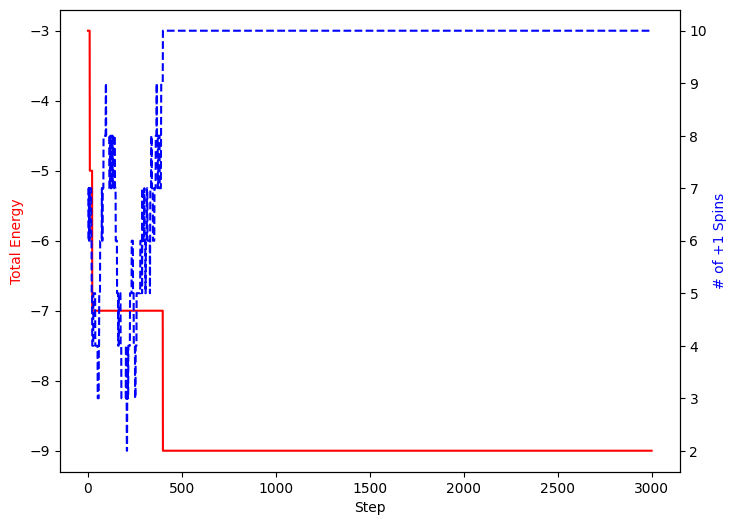

In [15]:
np.random.seed(1)
nstep = 3 * 10**3
results_ising, energies_ising = metropolis_ising_improved(nstep, n=10, J=1, T=0.3)
print("Mean energy:", np.mean(energies_ising))

num_1 = np.sum(results_ising == 1, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(range(nstep + 1), energies_ising, color='red', label='Total energy')
plt.xlabel('Step')
plt.ylabel('Total Energy', color='red')
plt.twinx()
plt.plot(range(nstep + 1), num_1, color='blue', linestyle='--', label='# of +1 Spins')
plt.ylabel('# of +1 Spins', color='blue')
plt.xlabel('Step')
plt.show()

For a higher temperature $T = 3$, it becomes much harder to sample the lowest energy state. Most sampled energy states are in the middle range. 


Acceptance rate: 0.6723333333333333
Mean energy: -2.923358880373209


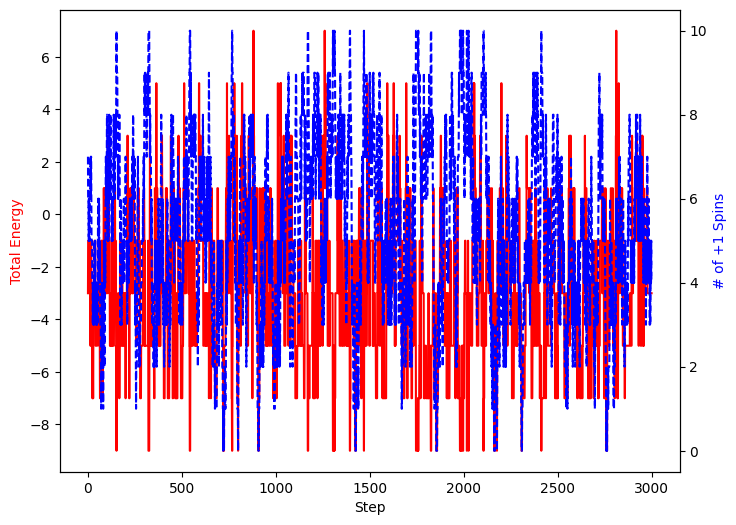

In [16]:
np.random.seed(1)
nstep = 3 * 10**3
results_ising, energies_ising = metropolis_ising_improved(nstep, n=10, J=1, T=3)
print("Mean energy:", np.mean(energies_ising))

num_1 = np.sum(results_ising == 1, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(range(nstep + 1), energies_ising, color='red', label='Total energy')
plt.xlabel('Step')
plt.ylabel('Total Energy', color='red')
plt.twinx()
plt.plot(range(nstep + 1), num_1, color='blue', linestyle='--', label='# of +1 Spins')
plt.ylabel('# of +1 Spins', color='blue')
plt.xlabel('Step')
plt.show()